# Dataset 

In [1]:
from pathlib import Path
from urllib.request import urlretrieve
import zipfile
from matplotlib.pyplot import imread
from scipy.ndimage.interpolation import zoom#
import numpy as np


def fetch_cropped_yaleb(data_folder, zooming=0.5, max_n_subjects=None):
    """Returns a dictionary of paths
    
    Parameters
    ----------
    data_folder: string
    zooming: float, optional, default is 0.5
        factor by which to resize the images
    max_n_subjects: {None, int}, optional, default is None
        if not None, only the first max_n_subjects are returned
    
    Returns
    -------
    dict: {
        subjects_1: {'images': [image_1, ... image_N],
               'ambient': image_ambient,
        }
    }
    
    images are stored as numpy arrays
    """
    url = 'http://vision.ucsd.edu/extyaleb/CroppedYaleBZip/CroppedYale.zip'
    yaleb_path = Path(data_folder).joinpath('cropped_yaleb')
    
    if not yaleb_path.joinpath('CroppedYale').exists():
        yaleb_path.mkdir(parents=True)
    
    # If not already unzip, do it
    if not list(yaleb_path.iterdir()):
        zip_path = yaleb_path.joinpath('yaleb.zip')
        
        # If zip not already downloaded, download it
        if not zip_path.exists():
            urlretrieve(url, zip_path.as_posix())
        
        zfile = zipfile.ZipFile(zip_path.as_posix())
        zfile.extractall(path=yaleb_path.as_posix())

    yaleb = {}
    for folder_path in yaleb_path.joinpath('CroppedYale').iterdir():
        if max_n_subjects is not None and len(yaleb) > max_n_subjects:
            return yaleb
        
        if not folder_path.is_dir():
            continue
            
        video_name = folder_path.name
        paths = sorted(list(folder_path.glob('*.pgm')))
        images = []
        for path in paths:
            if 'Ambient' in path.name:
                ambient = imread(path.as_posix())
            else:
                images.append(zoom(imread(path.as_posix()), zooming)[None, ...])
                
        data = {'images':np.concatenate(images),
        'ambient':ambient}
        yaleb[video_name] = data

    return yaleb

In [2]:
dataset_path = '/mnt/c/Users/nikhi/Documents/sem4/mis/project/data/'

data = fetch_cropped_yaleb(dataset_path, zooming=0.3, max_n_subjects=5)

In [3]:
X = np.concatenate([data[key]['images'] for key in data], axis=0)

print(X.shape)

(384, 58, 50)


In [4]:
AVG_FACE = X.mean(axis=0)
X =  X - AVG_FACE
print(X.shape)

(384, 58, 50)


In [5]:
def make_vector(images):
    return X.reshape((-1, 58*50))

def split_vector(image_vec):
    return image_vec.reshape((-1,58,50))

In [6]:
X = X.astype(np.float64)
X_vec = make_vector(X)

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

def visualise_images(X, n_images, n_columns, randomise=True):
    # indices = np.arange(X.shape[0])
    # np.random.shuffle(indices)
    # indices = indices[:n_images]
    indices = [5, 15, 25, 35, 45, 55, 65, 75, 85, 95, 105, 115]
    cmap = plt.cm.Greys_r
    n_rows = np.ceil(n_images / n_columns)
    fig = plt.figure(figsize=(2*n_columns, 2*n_rows))
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

    # plot the digits: each image is 8x8 pixels
    for i, e in enumerate(indices):
        ax = fig.add_subplot(n_rows, n_columns, i + 1, xticks=[], yticks=[])
        ax.imshow(X[e] + AVG_FACE, cmap=cmap, interpolation='nearest')

/tmp/ipykernel_409/2846876725.py:16: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax = fig.add_subplot(n_rows, n_columns, i + 1, xticks=[], yticks=[])


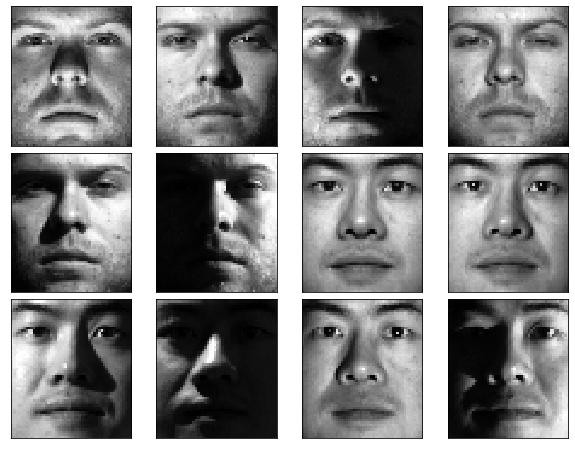

In [8]:
visualise_images(X, 12, 4)

In [9]:
def compute_rank_k_approximation(data, k):
    # centered = data - data.mean(axis=0)
    U, S, Vt = np.linalg.svd(data, full_matrices = False)
    approx = (U @ np.diag(S))[:, :k] @ Vt[:k]
    return approx
    # return pd.DataFrame(approx, columns = data.columns)

/tmp/ipykernel_409/2846876725.py:16: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax = fig.add_subplot(n_rows, n_columns, i + 1, xticks=[], yticks=[])


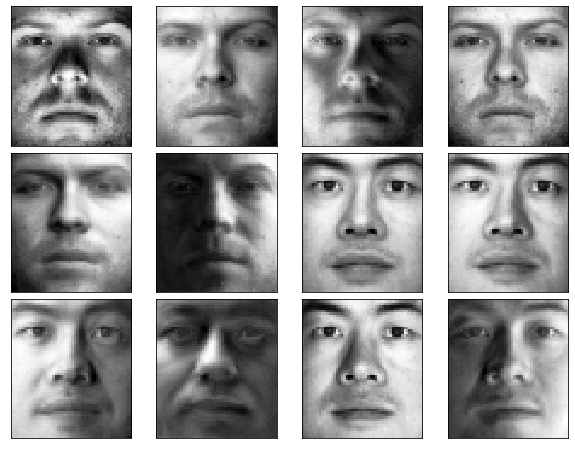

In [10]:
test = compute_rank_k_approximation(X_vec, 20)
visualise_images(split_vector(test), 12, 4)

## Salt and pepper 

In [11]:
def add_noise(img):
 
    # Getting the dimensions of the image
    row , col = img.shape
     
    # Randomly pick some pixels in the
    # image for coloring them white
    # Pick a random number between 300 and 10000
    number_of_pixels = np.random.randint(300, 10000)*5
    for i in range(number_of_pixels):
       
        # Pick a random y coordinate
        y_coord= np.random.randint(0, row - 1)
         
        # Pick a random x coordinate
        x_coord= np.random.randint(0, col - 1)
         
        # Color that pixel to white
        img[y_coord][x_coord] = 255
         
    # Randomly pick some pixels in
    # the image for coloring them black
    # Pick a random number between 300 and 10000
    number_of_pixels = np.random.randint(300 , 10000)*5
    for i in range(number_of_pixels):
       
        # Pick a random y coordinate
        y_coord= np.random.randint(0, row - 1)
         
        # Pick a random x coordinate
        x_coord= np.random.randint(0, col - 1)
         
        # Color that pixel to black
        img[y_coord][x_coord] = 0
         
    return img

In [12]:
salt_pepper = add_noise(X_vec)

/tmp/ipykernel_409/2846876725.py:16: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax = fig.add_subplot(n_rows, n_columns, i + 1, xticks=[], yticks=[])


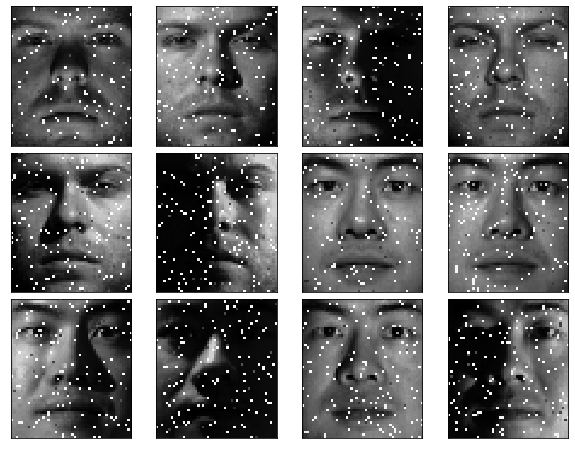

In [13]:
visualise_images(split_vector(salt_pepper), 12, 4)

/tmp/ipykernel_409/2846876725.py:16: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax = fig.add_subplot(n_rows, n_columns, i + 1, xticks=[], yticks=[])


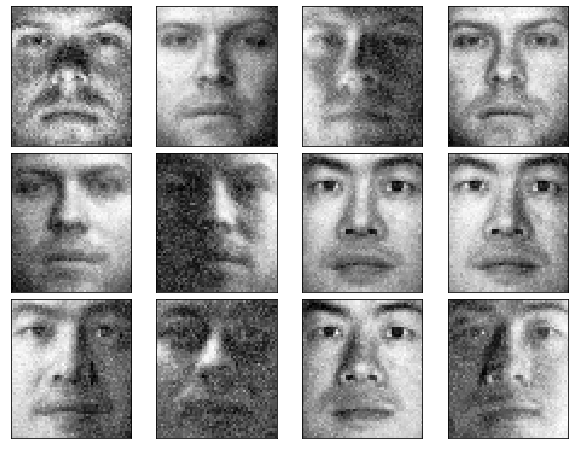

In [14]:
test = compute_rank_k_approximation(salt_pepper, 20)
visualise_images(split_vector(test), 12, 4)

In [15]:
import copy

In [16]:
def patch_noise(img):
    img_vec = copy.deepcopy(img)
    images = img_vec.reshape((-1,58,50))
    patch_size = 20
    for i in range(images.shape[0]):
        row_start = np.random.randint(0, images.shape[1]-patch_size)
        row_end = row_start + patch_size
        col_start = np.random.randint(0, images.shape[2]-patch_size)
        col_end = col_start + patch_size
        
        images[i, row_start:row_end, col_start:col_end] = 0
        
    return images.reshape(-1, 58*50)

/tmp/ipykernel_409/2846876725.py:16: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax = fig.add_subplot(n_rows, n_columns, i + 1, xticks=[], yticks=[])


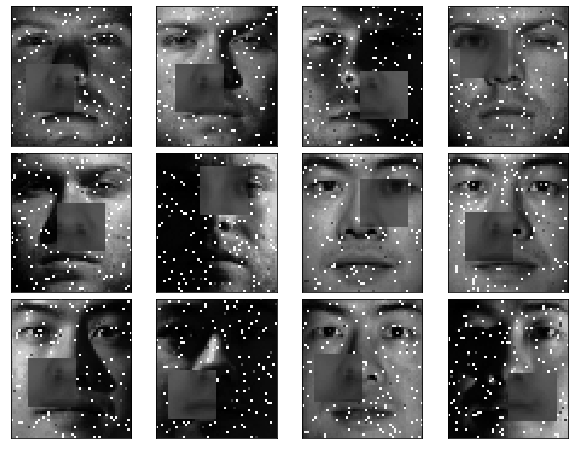

In [17]:
patched = patch_noise(X_vec)
visualise_images(split_vector(patched), 12, 4)

/tmp/ipykernel_409/2846876725.py:16: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax = fig.add_subplot(n_rows, n_columns, i + 1, xticks=[], yticks=[])


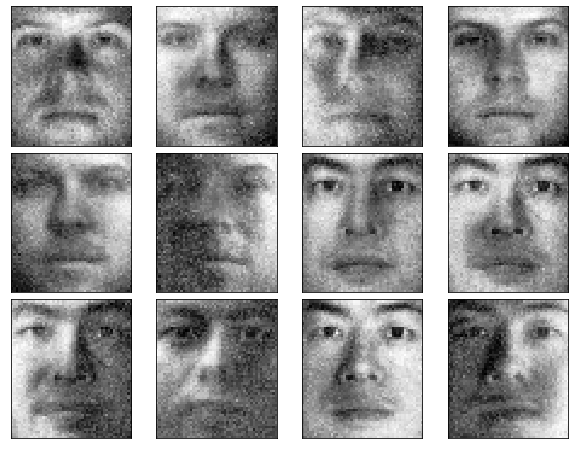

In [18]:
test = compute_rank_k_approximation(patched, 20)
visualise_images(split_vector(test), 12, 4)

# RPCA

In [19]:
import fbpca

In [20]:
TOL=1e-9
MAX_ITERS=3

In [21]:
def converged(Z, d_norm):
    err = np.linalg.norm(Z, 'fro') / d_norm
    print('error: ', err)
    return err < TOL

In [22]:
def shrink(M, tau):
    S = np.abs(M) - tau
    return np.sign(M) * np.where(S>0, S, 0)

In [23]:
def _svd(M, rank): return fbpca.pca(M, k=min(rank, np.min(M.shape)), raw=True)

In [24]:
def norm_op(M): return _svd(M, 1)[1][0]

In [25]:
def svd_reconstruct(M, rank, min_sv):
    u, s, v = _svd(M, rank)
    s -= min_sv
    nnz = (s > 0).sum()
    return u[:,:nnz] @ np.diag(s[:nnz]) @ v[:nnz], nnz

In [26]:
def pcp(X, maxiter=10, k=10): # refactored
    m, n = X.shape
    trans = m<n
    if trans: X = X.T; m, n = X.shape
        
    lamda = 1/np.sqrt(m)
    op_norm = norm_op(X)
    Y = np.copy(X) / max(op_norm, np.linalg.norm( X, np.inf) / lamda)
    mu = k*1.25/op_norm; mu_bar = mu * 1e7; rho = k * 1.5
    
    d_norm = np.linalg.norm(X, 'fro')
    L = np.zeros_like(X); sv = 1
    
    examples = []
    
    for i in range(maxiter):
        print("rank sv:", sv)
        X2 = X + Y/mu
        
        # update estimate of Sparse Matrix by "shrinking/truncating": original - low-rank
        S = shrink(X2 - L, lamda/mu)
        
        # update estimate of Low-rank Matrix by doing truncated SVD of rank sv & reconstructing.
        # count of singular values > 1/mu is returned as svp
        L, svp = svd_reconstruct(X2 - S, sv, 1/mu)
        
        # If svp < sv, you are already calculating enough singular values.
        # If not, add 20% (in this case 240) to sv
        sv = svp + (1 if svp < sv else round(0.05*n))
        
        # residual
        Z = X - L - S
        Y += mu*Z; mu *= rho
        
        examples.extend([S[140,:], L[140,:]])
        
        if m > mu_bar: m = mu_bar
        if converged(Z, d_norm): break
    
    if trans: L=L.T; S=S.T
    return L, S, examples

In [27]:
L, S, examples =  pcp(X_vec, maxiter=5, k=5)

rank sv: 1
error:  0.6476229030094055
rank sv: 20
error:  0.08490510956864812
rank sv: 39
error:  0.006785255896764944
rank sv: 35
error:  0.0004792609408430458
rank sv: 54
error:  2.9238499236503358e-05


/tmp/ipykernel_409/2846876725.py:16: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax = fig.add_subplot(n_rows, n_columns, i + 1, xticks=[], yticks=[])


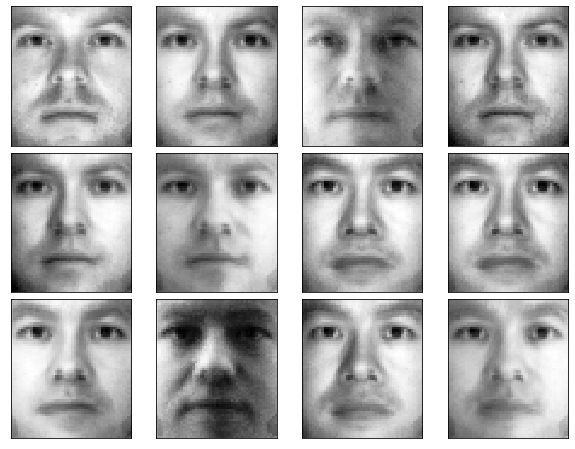

In [28]:
visualise_images(split_vector(L), 12, 4)

rank sv: 1
error:  0.6476461349324891
rank sv: 20
error:  0.08495157850487788
rank sv: 39
error:  0.006785790418249913
rank sv: 35
error:  0.0004791337713336348
rank sv: 54
error:  2.8529599220002943e-05


/tmp/ipykernel_409/2846876725.py:16: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax = fig.add_subplot(n_rows, n_columns, i + 1, xticks=[], yticks=[])


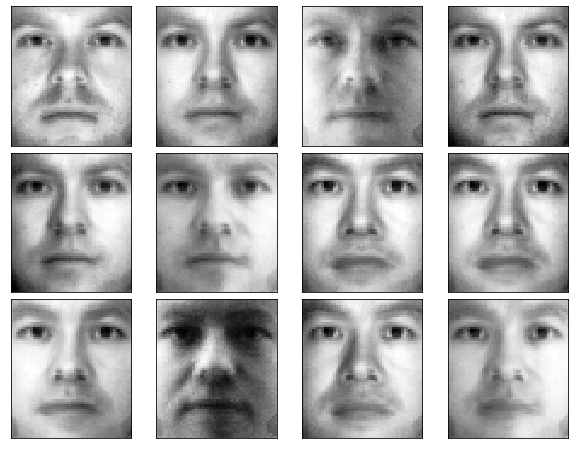

In [29]:
L, S, examples =  pcp(salt_pepper, maxiter=5, k=5)
visualise_images(split_vector(L), 12, 4)

rank sv: 1
error:  0.5978999454768964
rank sv: 20
error:  0.0619189768724076
rank sv: 39
error:  0.003330040236226622
rank sv: 58
error:  0.00015908234571351907
rank sv: 49
error:  6.973305872198729e-06


/tmp/ipykernel_409/2846876725.py:16: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax = fig.add_subplot(n_rows, n_columns, i + 1, xticks=[], yticks=[])


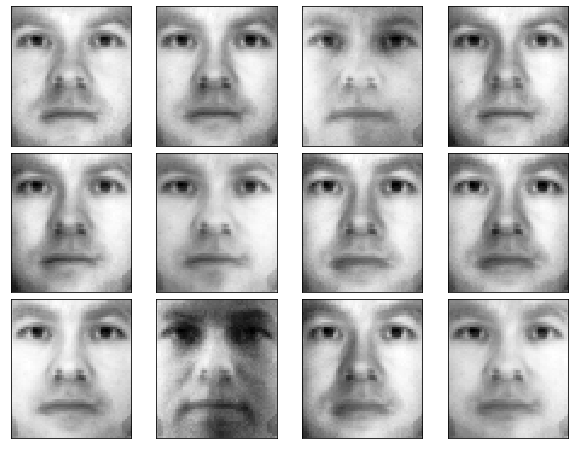

In [30]:
L, S, examples =  pcp(patched, maxiter=5, k=6)
visualise_images(split_vector(L), 12, 4)

/tmp/ipykernel_409/2846876725.py:16: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax = fig.add_subplot(n_rows, n_columns, i + 1, xticks=[], yticks=[])


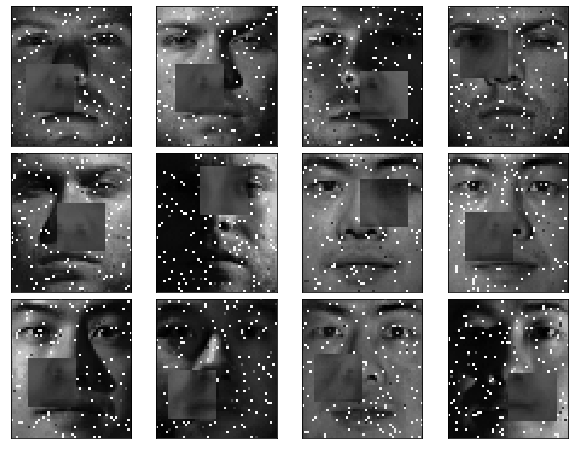

In [31]:
visualise_images(split_vector(S), 12, 4)

/tmp/ipykernel_409/2846876725.py:16: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax = fig.add_subplot(n_rows, n_columns, i + 1, xticks=[], yticks=[])


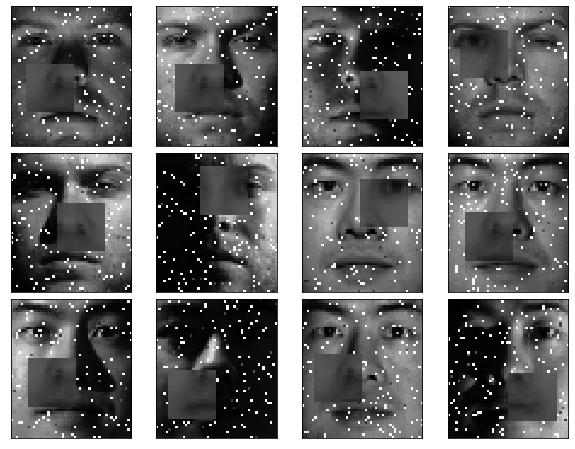

In [32]:
visualise_images(split_vector(L+S), 12, 4)